## Project: Write an Algorithm for Distracted Driver Detection 


* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Train a CNN with Transfer Learning (Using Fine-tuned VGG16)





In [1]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
import tensorflow as tf
from tensorflow import keras

<a id="step0"></a>
## Step 0: Import Datasets

### Import Driver Dataset

In the following code cell, we create a instance of ImageDataGenerator which does all preprocessing operations on images that we are going to feed to our CNN

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
        )


In the following code, we are loading only 32 images at once into memory and performing all the preprocessing operations on loaded images. The flow_from_directory loads a defined set of images from the location of images, instead of loading all images at once into memory.

- train_generator contains training set
- val_generator contains validation set

In [3]:
train_data = '../input/state-farm-distracted-driver-detection/imgs/train'
test_data = '../input/state-farm-distracted-driver-detection/imgs/test'
train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [4]:
from PIL import Image

ac_labels=  ["c0: safe driving",
"c1: texting - right",
"c2: talking on the phone - right",
"c3: texting - left",
"c4: talking on the phone - left",
"c5: operating the radio",
"c6: drinking",
"c7: reaching behind",
"c8: hair and makeup",
"c9: talking to passenger"]


In [5]:
imgs, labels = next(train_generator)

## Dataset Exploration
- Following code block explores and reveals the dataset

In [6]:
import functools

def list_counts(start_dir):
    lst = sorted(os.listdir(start_dir))
    out = [(fil, len(os.listdir( os.path.join(start_dir, fil)))) for fil in lst if os.path.isdir(os.path.join(start_dir,fil))]
    return out

out = list_counts(train_data)
labels, counts = zip(*out)
print("Total number of images : ",functools.reduce(lambda a,b : a+b, counts))
out

Total number of images :  22424


[('c0', 2489),
 ('c1', 2267),
 ('c2', 2317),
 ('c3', 2346),
 ('c4', 2326),
 ('c5', 2312),
 ('c6', 2325),
 ('c7', 2002),
 ('c8', 1911),
 ('c9', 2129)]

## Data Visualization
Following code block. displays images and their respective labels of training/ validation dataset

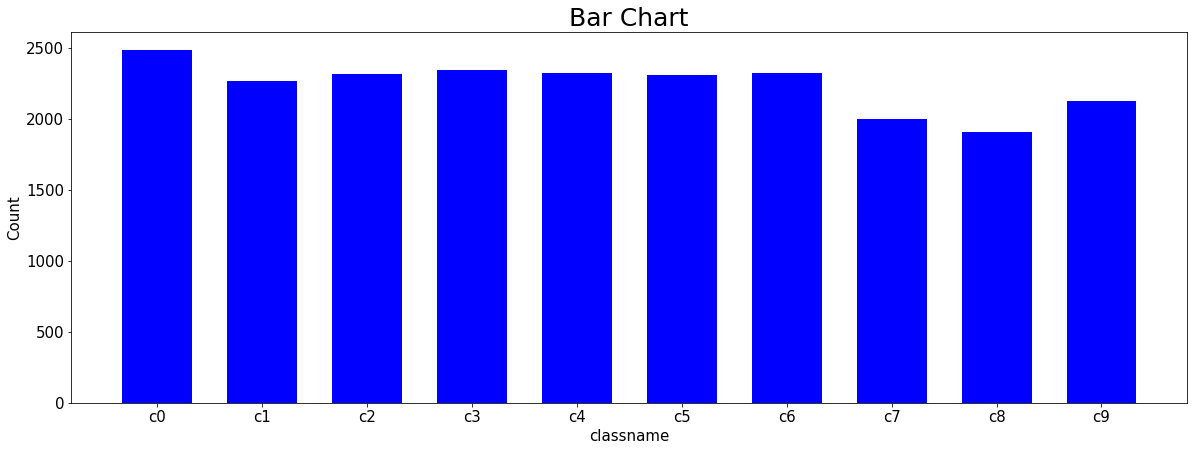

Label :  c0: safe driving


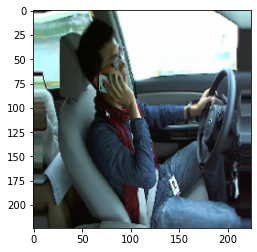

In [7]:

import matplotlib.pyplot as plt
import pandas as pd
# Pretty display for notebooks
%matplotlib inline


y = np.array(counts)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()



def showImages(imgs ,inlabels=None, single=True):
    if single:
        aim = (imgs * 255 ).astype(np.uint8)
        img = Image.fromarray(aim)
        if labels is not None:
            print("Label : ", ac_labels[np.argmax(inlabels)])
        plt.imshow(img)
        plt.show()
    else:
        for i,img in enumerate(imgs):
            lbl = None
            if inlabels is not None:
                lbl = labels[i]
            showImages(img, lbl)

ind = 1
showImages(imgs[:ind], inlabels=labels[:ind], single = False)


---
<a id="step1"></a>
##  Step 1: Train a CNN with Transfer Learning (Using Fine-tuned VGG16 Model)

- In the following steps, we are going to load a VGG16 model, without top Fully connected layers, with its trained weights
- Then we are going add Fully Connected Layers on top of GlobalAveragePooling layer with Dropout layers in between
- The following code block contains a method load_VGG16, which loads VGG16 model with weights loaded when weights file location is given

In [8]:

def load_VGG16(weights_path=None, no_top=True):

    input_shape = (224, 224, 3)

    #Instantiate an empty model
    img_input = Input(shape=input_shape)   # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = GlobalAveragePooling2D()(x)
    vmodel = Model(img_input, x, name='vgg16')
    if weights_path is not None:
        print("Weights have been loaded.")
        vmodel.load_weights(weights_path)

    return vmodel


- In the following code block, we have added 3 Dense layers with dropout layers on top of VGG16 CNN model.

In [9]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras import regularizers
vgg_model_raw = load_VGG16('../input/weights-vgg16h5/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg_model = vgg_model_raw.output
#vgg_model = Flatten()(vgg_model)
vgg_model = Dense(5000, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
#vgg_model = Dropout(0.1)(vgg_model)
#vgg_model = Dense(1000, activation='relu')(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(10, activation='softmax')(vgg_model)
vgg_m = Model(inputs=vgg_model_raw.input, outputs= vgg_model)

Weights have been loaded.


In [10]:
vgg_m.layers[16].get_weights()

[array([[[[-1.12610648e-03, -1.39102731e-02, -4.15291899e-04, ...,
           -2.39090272e-03,  5.59418183e-03, -1.67810004e-02],
          [ 1.13813886e-02, -6.83033955e-04, -8.76976922e-03, ...,
           -8.44151899e-03, -3.70610040e-03,  1.24894250e-02],
          [ 2.18971120e-03,  1.76711346e-03,  1.23967733e-02, ...,
            1.34555586e-02,  1.07239345e-02,  5.72480168e-03],
          ...,
          [-8.70769471e-03,  4.26163105e-03, -7.06244586e-03, ...,
            1.54851489e-02,  4.63837199e-03,  7.84500409e-03],
          [-6.56485325e-04,  7.68889068e-03, -1.45298289e-03, ...,
           -7.35005224e-03, -3.10419098e-04,  8.47741403e-03],
          [ 5.95664885e-03, -3.27580003e-03, -5.32116368e-03, ...,
           -2.03936966e-03,  1.35865889e-03,  5.91904763e-03]],
 
         [[ 2.12769513e-03, -5.14811045e-03, -5.62243350e-03, ...,
           -1.31134260e-02,  4.88865655e-03, -1.01500070e-02],
          [ 1.17016789e-02, -7.15120370e-03, -8.39244854e-03, ...,
     

### Compile the vgg16 model with categorical crossentropy as loss function and SGD as optimizer

In [11]:
vgg_m.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(0.001), metrics=['accuracy'])


In [12]:
vgg_m.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

- Create a Checkpoint to save best weights, when loss in improvised
- Train the model for 6 epochs

In [13]:

checkpoint = ModelCheckpoint('vgg_model_finetuned.h5', save_best_only=True, verbose=1)

history = vgg_m.fit(train_generator, steps_per_epoch=len(train_generator),
                   epochs=10,
                   validation_data = val_generator,
                   validation_steps=len(val_generator),
                   callbacks=[checkpoint] )

Epoch 1/10
561/561 [==============================] - ETA: 0s - loss: 2.3052 - accuracy: 0.1357
Epoch 00001: val_loss improved from inf to 2.26299, saving model to vgg_model_finetuned.h5
561/561 [==============================] - 487s 868ms/step - loss: 2.3052 - accuracy: 0.1357 - val_loss: 2.2630 - val_accuracy: 0.1939
Epoch 2/10
561/561 [==============================] - ETA: 0s - loss: 1.9949 - accuracy: 0.3048
Epoch 00002: val_loss improved from 2.26299 to 1.67112, saving model to vgg_model_finetuned.h5
561/561 [==============================] - 371s 661ms/step - loss: 1.9949 - accuracy: 0.3048 - val_loss: 1.6711 - val_accuracy: 0.4345
Epoch 3/10
561/561 [==============================] - ETA: 0s - loss: 1.0042 - accuracy: 0.6710
Epoch 00003: val_loss improved from 1.67112 to 0.53011, saving model to vgg_model_finetuned.h5
561/561 [==============================] - 371s 661ms/step - loss: 1.0042 - accuracy: 0.6710 - val_loss: 0.5301 - val_accuracy: 0.8536
Epoch 4/10
561/561 [======

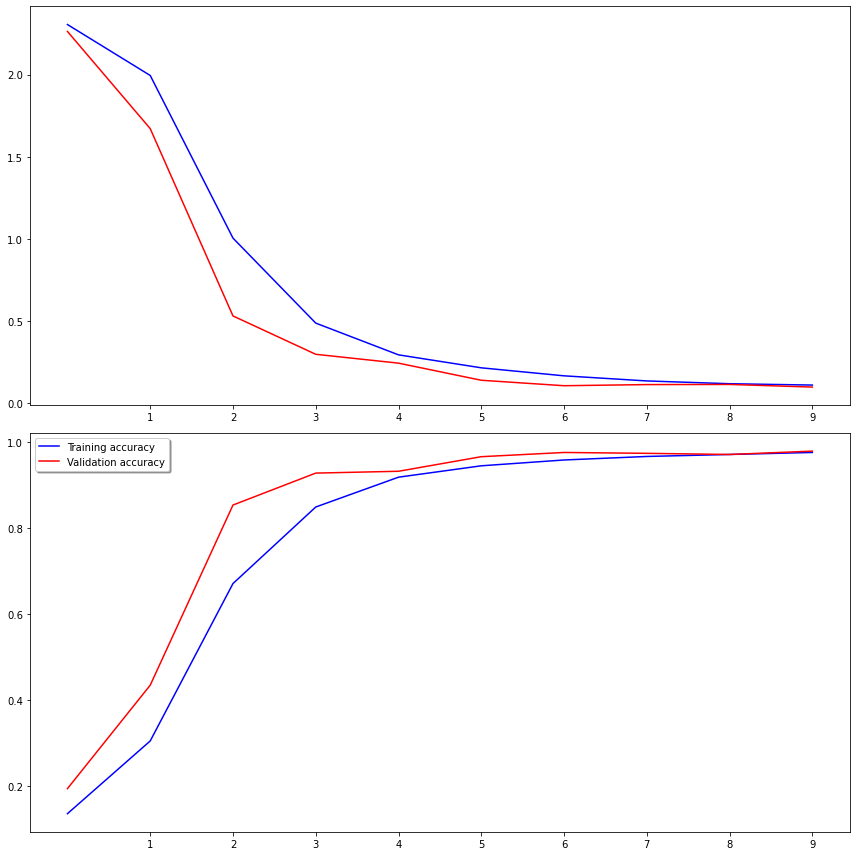

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 10, 1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 10, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()